<a href="https://colab.research.google.com/github/yachu33/evolution-strategy-algorithm-for-hedging/blob/master/ES_for_Hedging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. 資料前處理

In [0]:
import numpy as np

# read data

## 2. Evolution Strategies 

In [0]:
import matplotlib.pyplot as plt
import sys
import numpy as np

class ES(object):
    
    def __init__(self, POP_SIZE, n_kids):
        self.POP_SIZE = POP_SIZE
        self.n_kids = n_kids
        self.DMpop = dict(DNA = np.random.dirichlet(np.ones(9),size = self.POP_SIZE),
                     mut_step = np.tile(np.repeat(3.0, 9), (self.POP_SIZE, 1)))
        self.BPpop = dict(DNA = np.random.dirichlet(np.ones(9),size=self.POP_SIZE),
                     mut_step = np.tile(np.repeat(3.0, 9), (self.POP_SIZE, 1)))

    # generate n_kids 
    def make_kids(self):

        DMkids = {'DNA': np.empty((self.n_kids, 9)),
                  'mut_step': np.empty((self.n_kids, 9))}  # n_kids, DNA_size

        BPkids = {'DNA': np.empty((self.n_kids, 9)), 
                  'mut_step': np.empty((self.n_kids, 9))}  # n_kids, DNA_size

        for i in range(self.n_kids):
            DMp1, DMp2 = np.random.choice(np.arange(self.POP_SIZE), size=2, replace=False)
            DMp1_DNA = self.DMpop['DNA'][DMp1]
            DMp1_mut = self.DMpop['mut_step'][DMp1]
            DMp2_DNA = self.DMpop['DNA'][DMp2]
            DMp2_mut = self.DMpop['mut_step'][DMp2]
            
            DMkids['DNA'][i], DMkids['mut_step'][i] = self.mutate(DMp1_DNA, DMp1_mut, DMp2_DNA, DMp2_mut)
            
            BPp1, BPp2 = np.random.choice(np.arange(self.POP_SIZE), size=2, replace=False)
            BPp1_DNA = self.BPpop['DNA'][BPp1]
            BPp1_mut = self.BPpop['mut_step'][BPp1]
            BPp2_DNA = self.BPpop['DNA'][BPp2]
            BPp2_mut = self.BPpop['mut_step'][BPp2]
            
            BPkids['DNA'][i], BPkids['mut_step'][i] = self.mutate(BPp1_DNA, BPp1_mut, BPp2_DNA, BPp2_mut)
            
        DMkids['DNA'] = self.normalizeDNA(DMkids['DNA']) #only DNA parts need to be normalized
        BPkids['DNA'] = self.normalizeDNA(BPkids['DNA'])


        return DMkids, BPkids    

    def mutate(self, p1_DNA, p1_mut, p2_DNA, p2_mut):
#         print('in')
        first_modify_part = np.random.standard_normal() # fixed in every solution
        kid_mut = np.empty_like(p1_mut)
        kid_DNA = np.empty_like(p1_DNA)

        for i in range(np.array(kid_mut).size):
            
            modify = first_modify_part + np.random.standard_normal()
            kid_mut[i] = np.mean(p1_mut+p2_mut) * np.exp(modify)
            kid_DNA[i] = np.round(np.maximum(p1_DNA[i] + np.random.normal(0, kid_mut[i]), 0.00000001), 8) # variable > 0
            
        
        return kid_DNA, kid_mut

    def normalizeDNA(self, kids):
        sum_vec = np.sum(kids, axis = 1) # calculate sum of each solution
        sum_vec = np.round(sum_vec, 8)
        norm_kids = kids/sum_vec[:, None] # normalize
        norm_kids = np.round(norm_kids, 8)
        
        return norm_kids

    # select the best POP_SIZE kids as parents
    def kill_bad(self, DMkids, BPkids, fitness):
        #return the best POP_SIZE kids
        pop_indices = np.argsort(fitness)[-self.POP_SIZE:]
        self.DMpop = {"DNA": np.array(DMkids["DNA"])[np.array(pop_indices)],
                 "mut_step": np.array(DMkids["mut_step"])[np.array(pop_indices)]}
        self.BPpop = {"DNA": np.array(BPkids["DNA"])[np.array(pop_indices)],
                 "mut_step": np.array(BPkids["mut_step"])[np.array(pop_indices)]}

        return self.DMpop, self.BPpop

## Hedging proccess

In [0]:
class Hedge(object):
    def __init__(self):
        self.ExRate = np.genfromtxt('SimExRatesFall19.csv', delimiter=',', skip_header = 1)
        revUS_base = np.empty((1000,1))
        for i in range(1000):
            DMtoUS_base_s = self.HedgeRevDM_base(deltaDM = self.ExRate[i, 0])
            BPtoUS_base_s = self.HedgeRevBP_base(deltaBP = self.ExRate[i, 1])
            revUS_base[i] = DMtoUS_base_s + BPtoUS_base_s
        self.revUS_base = revUS_base
        self.putDM = [[0.66,0.085855],[0.65,0.032191],[0.64,0.020795],[0.63,0.017001],
                 [0.62,0.013711],[0.61,0.010851],[0.60,0.008388],[0.59,0.006291],
                 [0.55,0.001401]]
        self.putBP = [[1.3,0.137213],[1.25,0.082645],[1.20,0.0450460],[1.15,0.028348],
                 [1.1,0.016146],[1.05,0.007860],[1,0.003277],[0.95,0.001134],
                 [0.9,0.000245]]

    def HedgeRevDM_base(self, deltaDM, DMfcst=645, currentDM=0.6513):
       
        return DMfcst*currentDM*(1+deltaDM/100)

    def HedgeRevBP_base(self, deltaBP, BPfcst=272, currentBP=1.234):

        return BPfcst*currentBP*(1+deltaBP/100)
    
    def HedgeRevDM_opt(self, nDM, kDM, cDM, deltaDM, DMfcst=645, currentDM=0.6513):
       
        return nDM*(max(kDM-currentDM*(1+deltaDM/100),0)-cDM)
    
    def HedgeRevBP_opt(self, nBP,kBP,cBP,deltaBP,BPfcst=272, currentBP=1.234):
        
        return nBP*(max(kBP-currentBP*(1+deltaBP/100),0)-cBP)
    
    def calculate_expectation(self, DM_DNAs, BP_DNAs, CEO):
        n_kids = len(DM_DNAs)
        n_options = len(DM_DNAs[0])
        
        # all DNAs ratio multiply 500 budget
        nDM_vector = np.array(DM_DNAs) * 500 
        nBP_vector = np.array(BP_DNAs) * 500
        
        revUS_opt_temp = np.zeros((1000, n_kids))
        revUS_opt = np.zeros((n_options, 1000, n_kids))
        for i in range(n_options):
            for s in range(1000):
                DMtoUS_opt_s = self.HedgeRevDM_opt(nDM_vector[:,i], self.putDM[i][0], self.putDM[i][1],
                              self.ExRate[s, 0])
                BPtoUS_opt_s = self.HedgeRevBP_opt(nBP_vector[:,i], self.putBP[i][0], self.putBP[i][1],
                              self.ExRate[s, 1])
                revUS_opt_temp[s] = DMtoUS_opt_s + BPtoUS_opt_s
            revUS_opt[i,:] = revUS_opt_temp
            
        revUS_base = np.repeat(self.revUS_base, n_kids, axis = 1)  # repeat base revUS n_kids times
        revUS = np.sum(revUS_opt, axis = 0) + revUS_base # sum all options rev and base rev
        if (CEO):
            fitness = np.mean(revUS, axis = 0) # get mean rev of every kid
            
        else:
            fitness = np.sum( (revUS>=706), axis = 0)/1000

        return fitness

    

## Main

In [0]:
import time

#np.seterr(all='raise')
def evolution(POP_SIZE, n_kids, N_GENERATIONS, CEO = 1):   
    GENERATION_BEST = []
    GENERATION = []
    GLOBAL_BEST = 0
    es = ES(POP_SIZE, n_kids)
    start_time = time.time()
    
    for generation in range(N_GENERATIONS):
        DMkids, BPkids = es.make_kids()
        hedge = Hedge()
        fitness = hedge.calculate_expectation(DMkids['DNA'], BPkids['DNA'], CEO)
        DMpop, BPpop = es.kill_bad(DMkids, BPkids, fitness)
        
        best_fitness = np.max(fitness)
#         print('fitness', fitness)
#         print('best_fitness:', best_fitness)
        GENERATION_BEST.append(best_fitness)
        GENERATION.append(generation+1)
        
        GLOBAL_BEST = best_fitness if best_fitness > GLOBAL_BEST else GLOBAL_BEST
        bestIdx = np.argmax(fitness)
        DM_option = DMkids['DNA'][bestIdx]*500
        BP_option = BPkids['DNA'][bestIdx]*500
        
        if generation == N_GENERATIONS-1:
            exec_time =  time.time() - start_time
            
            plt.cla()
            plt.plot(GENERATION, GENERATION_BEST, 'r-')
            plt.xlim((0, N_GENERATIONS))
#             plt.ylim((0, np.max(GENERATION_BEST)))
            plt.pause(0.01)
            
            bestIdx = np.argmax(fitness)
            
            print('exec_time:', exec_time)
            print('DM_option:', DMkids['DNA'][bestIdx]*500)
            print('BP_option:', BPkids['DNA'][bestIdx]*500)
            if (CEO):
                print('Max Exp:', GLOBAL_BEST)
            else:
                print('More than USD $706 Prob:', GLOBAL_BEST)
                print('1-prob:', 1-GLOBAL_BEST)
 
    return exec_time, GLOBAL_BEST
    
    

### Calculate Maximun Expectation Rev

---------POP SIZE: 50 ------------


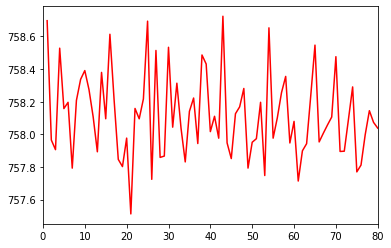

exec_time: 29.947521209716797
DM_option: [  0.        0.        0.        0.       62.89721   0.      210.03126
 220.39331   6.67822]
BP_option: [  0.         0.         0.         0.         7.103325   0.
   0.       172.002015 320.894655]
Max Exp: 758.7241366830027


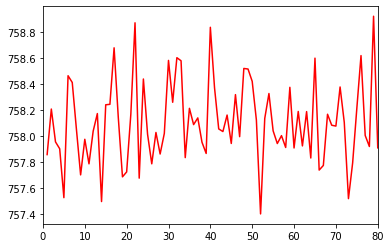

exec_time: 29.290317058563232
DM_option: [  0.         2.4365     0.         0.        23.27713  115.226545
   0.         0.       359.059825]
BP_option: [  0.        0.        0.       13.64814   0.        0.      486.35186
   0.        0.     ]
Max Exp: 758.9226141533906


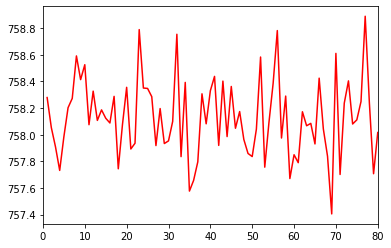

exec_time: 29.543962001800537
DM_option: [  0.         0.         0.       303.638505   0.         0.
   0.       101.451965  94.909535]
BP_option: [  0.        0.        0.        0.        0.        0.        2.73673
   0.      497.26327]
Max Exp: 758.8904238141786


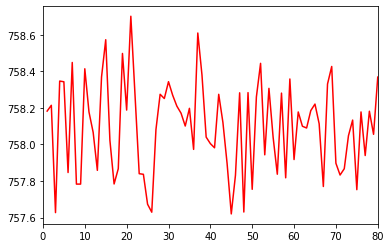

exec_time: 29.241525411605835
DM_option: [  0.   0.   0.   0.   0.   0.   0.   0. 500.]
BP_option: [  0.        0.       32.39248   0.        0.        0.      196.75311
 270.85441   0.     ]
Max Exp: 758.7015530621815


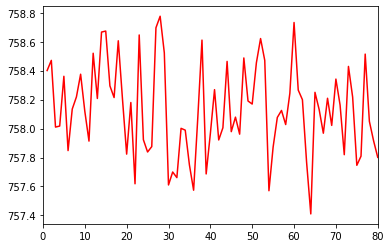

exec_time: 32.21967363357544
DM_option: [  0.        17.616255   7.389055   0.         0.        44.344045
 141.99067    0.       288.659975]
BP_option: [  0.        0.        0.        0.        0.        0.      476.13383
  23.86617   0.     ]
Max Exp: 758.7757255047671
Mean_Time: 32.21967363357544
Mean Fitness: 758.802890643504
---------POP SIZE: 60 ------------


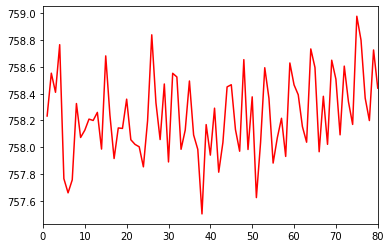

exec_time: 34.663219928741455
DM_option: [  0.         7.45436   37.97109    0.         0.        61.469205
 110.52092    0.       282.584425]
BP_option: [  0.        0.        0.        0.        0.        0.        0.
  66.67497 433.32503]
Max Exp: 758.9783018756856


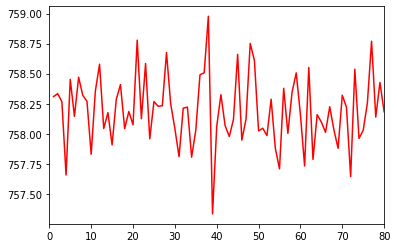

exec_time: 33.924914836883545
DM_option: [  0.         0.       133.00158   36.937605  15.62948    0.
  43.052875   0.83146  270.547   ]
BP_option: [  0.         0.         0.        26.64888    0.         0.
   7.3056     0.       466.045525]
Max Exp: 758.9778923244384


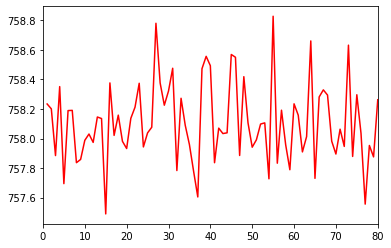

exec_time: 33.51502799987793
DM_option: [  0.        0.        0.        0.        0.      110.46597   0.
   0.      389.53403]
BP_option: [  0.         0.         8.95118    0.        33.97666    0.
 161.688735   0.       295.383425]
Max Exp: 758.8283159826168


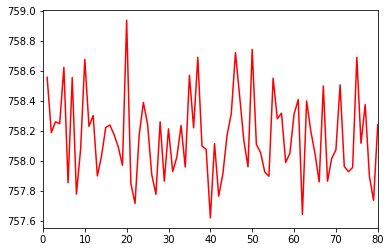

exec_time: 33.40651798248291
DM_option: [  2.703745   0.        20.63312   29.879      0.        28.856215
   0.        86.054    331.87392 ]
BP_option: [  0.         0.         0.         0.        46.557445   0.
   0.         0.       453.442555]
Max Exp: 758.9368697272243


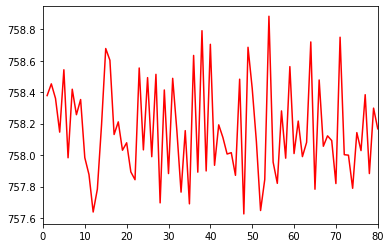

exec_time: 39.57735300064087
DM_option: [  0.         0.         0.         6.50844   52.810795   0.
   0.       440.68077    0.      ]
BP_option: [  0.        0.        0.        0.        0.        0.        0.
 166.30224 333.69776]
Max Exp: 758.8828865202061
Mean_Time: 39.57735300064087
Mean Fitness: 758.9208532860342
---------POP SIZE: 70 ------------


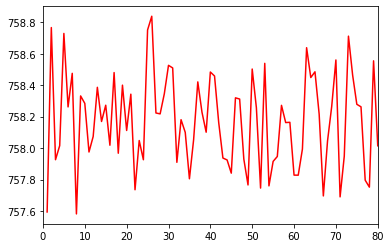

exec_time: 41.470577001571655
DM_option: [  2.758265   0.        19.58705    0.         0.        60.103185
  93.551785   0.       323.999715]
BP_option: [  0.         0.         0.         0.         0.         0.
 282.043715 217.956285   0.      ]
Max Exp: 758.8388750738527


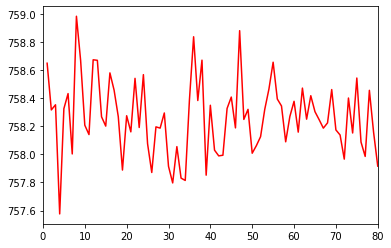

exec_time: 38.53181600570679
DM_option: [  0.         0.         0.         0.         0.         0.
  11.43676  487.011245   1.551995]
BP_option: [  0.        0.        0.        0.        0.        0.      288.58181
   0.      211.41819]
Max Exp: 758.9819192022419


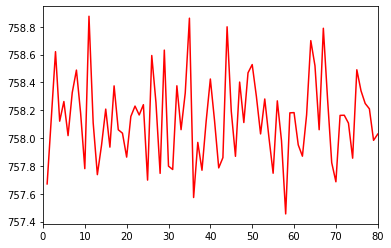

exec_time: 39.06535768508911
DM_option: [  0.         0.        43.079315   0.         0.       361.07709
  19.296375   0.        76.54722 ]
BP_option: [  0.   0.   0.   0.   0.   0.   0.   0. 500.]
Max Exp: 758.876080029184


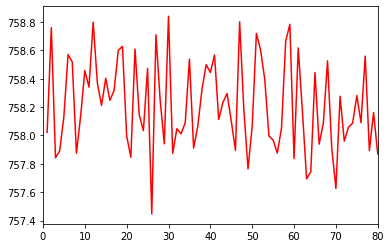

exec_time: 43.051416873931885
DM_option: [  0.         6.536625   6.76917    0.         0.        98.34346
   0.       388.350745   0.      ]
BP_option: [  0.         0.         0.        25.155265   0.         0.
   0.       263.73964  211.105095]
Max Exp: 758.8414580624808


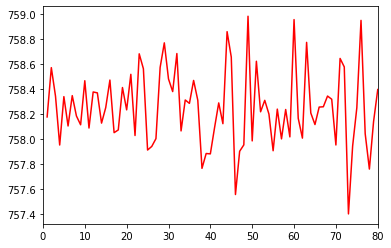

exec_time: 48.16867113113403
DM_option: [  0.       22.31287   0.        0.        0.        0.        0.
   0.      477.68713]
BP_option: [  2.475925   0.         0.         0.        42.937095   0.
   0.        31.355125 423.231855]
Max Exp: 758.980954904253
Mean_Time: 48.16867113113403
Mean Fitness: 758.9038574544024
---------POP SIZE: 80 ------------


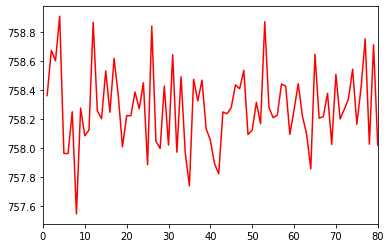

exec_time: 44.340227127075195
DM_option: [  0.        0.       72.50674   0.       43.00311   0.        0.
 384.49015   0.     ]
BP_option: [  0.       0.       0.       0.       0.      38.4728   0.       0.
 461.5272]
Max Exp: 758.9075714285781


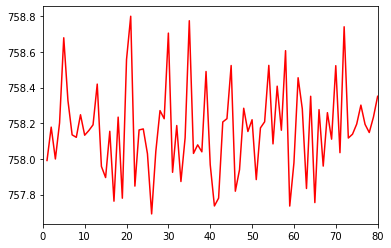

exec_time: 48.11023831367493
DM_option: [  0.         0.         0.       106.316525   0.         0.
   3.704645   5.837275 384.141555]
BP_option: [  0.         0.         0.        20.400845   0.        41.51213
  21.97261   39.226955 376.887455]
Max Exp: 758.8001620827844


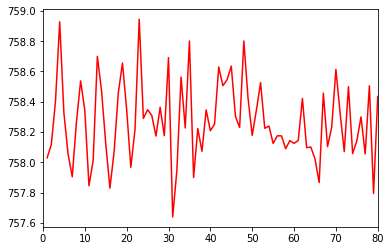

exec_time: 51.487764835357666
DM_option: [  0.         0.         0.         0.        20.906195   0.
   0.        32.31246  446.781345]
BP_option: [  0.         0.         0.         0.         0.       138.382335
   0.         0.       361.617665]
Max Exp: 758.9436331537524


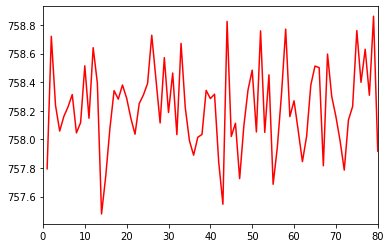

exec_time: 50.90823292732239
DM_option: [  0.        0.       89.25498   0.       14.84678   0.      201.44483
 194.45341   0.     ]
BP_option: [  0.         0.         0.         0.         0.         2.28957
 103.219855   0.       394.49057 ]
Max Exp: 758.8605778238165


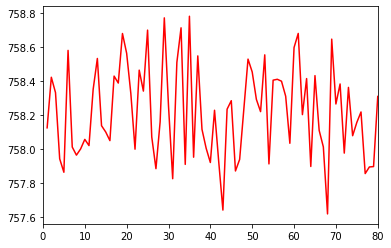

exec_time: 43.42905807495117
DM_option: [  0.         0.         0.         0.         5.400645   0.
   0.        15.62144  478.977915]
BP_option: [  0.         0.         0.         0.         0.        13.706765
 452.43914    0.        33.854095]
Max Exp: 758.780856967479
Mean_Time: 43.42905807495117
Mean Fitness: 758.8585602912821
---------POP SIZE: 90 ------------


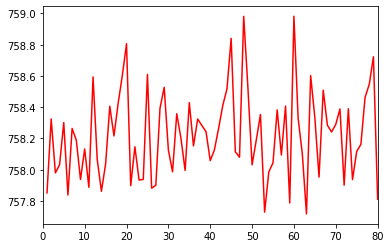

exec_time: 48.92788290977478
DM_option: [  0.        12.890915   0.         0.       248.977165 109.84433
  80.051975   0.        48.23562 ]
BP_option: [  0.         0.         0.         0.         0.         0.
   0.        88.853035 411.146965]
Max Exp: 758.9819192022419


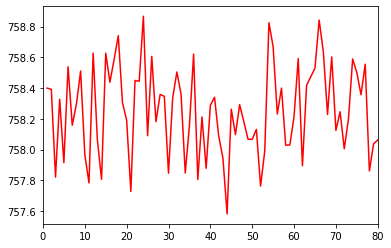

exec_time: 46.70502281188965
DM_option: [  0.         0.       109.49295    2.02707    0.         0.
   0.         0.       388.479975]
BP_option: [  0.         0.         0.        52.451015   0.        19.86145
   5.11658  409.587945  12.98301 ]
Max Exp: 758.867488520451


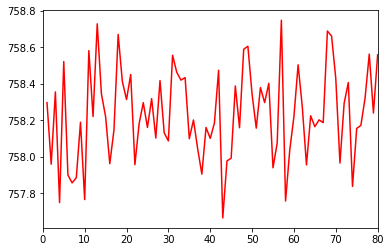

exec_time: 46.52055907249451
DM_option: [  0.         0.         4.26524    0.         1.407935   0.
   0.         0.       494.32683 ]
BP_option: [  0.         0.         0.         0.         0.       102.14895
  37.821235  69.813275 290.216545]
Max Exp: 758.7478799444748


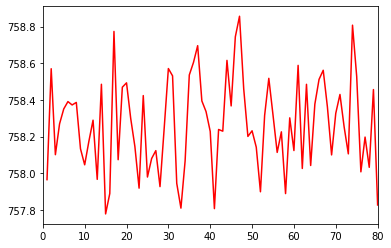

exec_time: 47.13161087036133
DM_option: [  0.        20.60869   10.21949   50.48001  211.948645   0.
   1.231475  93.97081  111.540885]
BP_option: [  0.         0.         0.         4.243395   0.         0.
  71.887235   0.       423.86937 ]
Max Exp: 758.8567873449564


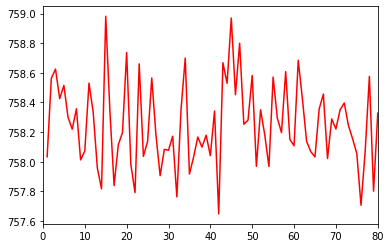

exec_time: 47.85185480117798
DM_option: [  0.         0.        73.08509    0.         0.         3.347975
   0.         2.07031  421.496625]
BP_option: [  0.         0.         0.        16.73955   54.749545   0.
   2.119115   4.23601  422.15578 ]
Max Exp: 758.9818600335574
Mean_Time: 47.85185480117798
Mean Fitness: 758.8871870091364
---------POP SIZE: 100 ------------


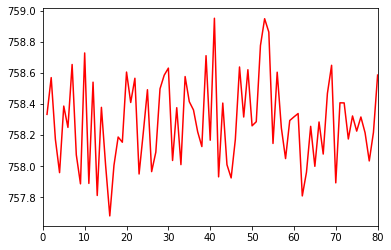

exec_time: 51.25123381614685
DM_option: [  0.         0.         0.         0.         1.170375   0.
  94.558555   9.32847  394.9426  ]
BP_option: [  0.        0.        0.        0.        0.        0.      158.00558
   0.      341.99442]
Max Exp: 758.9535719660363


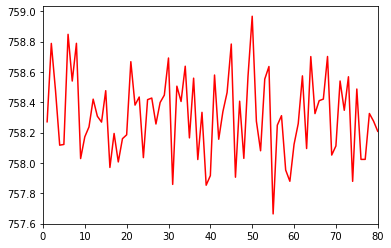

exec_time: 53.52753806114197
DM_option: [  0.         0.         0.       105.85537   43.100315  75.251995
   0.         5.94118  269.85114 ]
BP_option: [  0.         0.         0.         0.         0.         0.
  89.42104  241.547945 169.031015]
Max Exp: 758.9664554137546


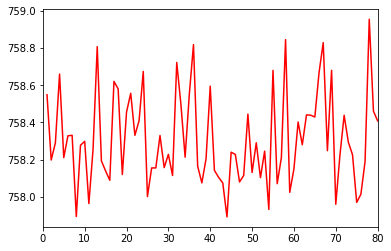

exec_time: 51.36318612098694
DM_option: [  0.   0.   0.   0.   0.   0.   0.   0. 500.]
BP_option: [  0.        0.        0.        0.        0.        0.      438.77336
   0.       61.22664]
Max Exp: 758.9532592014202


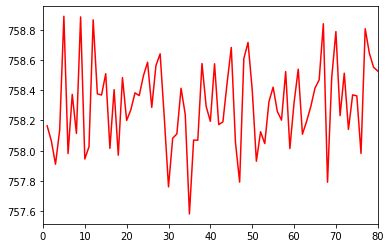

exec_time: 50.59441685676575
DM_option: [  0.         0.         0.         0.         0.        86.499755
   0.         0.       413.500245]
BP_option: [  0.        0.        0.       26.22339   0.       13.39544   0.
  77.82438 382.55679]
Max Exp: 758.8894015322787


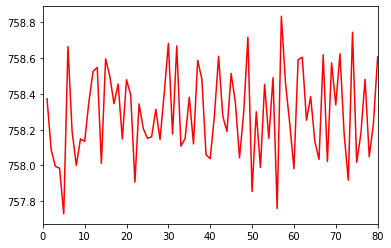

exec_time: 51.00064992904663
DM_option: [  1.67734    0.         0.         1.818875   3.10931    0.
   0.        59.58488  433.80959 ]
BP_option: [  0.   0.   0.   0.   0.   0.   0. 500.   0.]
Max Exp: 758.8348432001444
Mean_Time: 51.00064992904663
Mean Fitness: 758.9195062627269
---------POP SIZE: 110 ------------


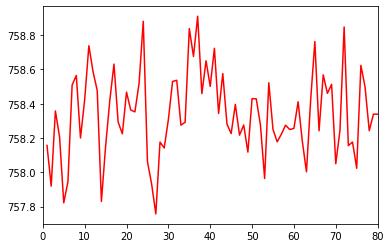

exec_time: 55.317769050598145
DM_option: [  0.        0.        0.        0.        0.        0.       90.11195
   0.      409.88805]
BP_option: [  0.        0.       60.40077   0.        0.        0.        0.
   0.      439.59923]
Max Exp: 758.910185422044


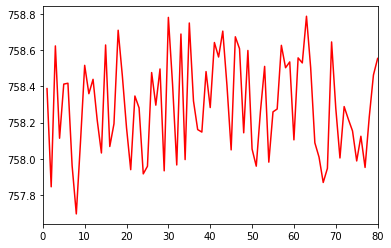

exec_time: 54.92825198173523
DM_option: [  0.         0.         0.         0.       161.85686    9.62872
   0.         0.       328.514425]
BP_option: [  0.   0.   0.   0.   0.   0.   0.   0. 500.]
Max Exp: 758.7882745298243


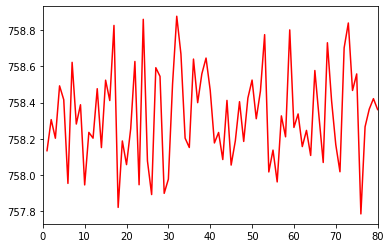

exec_time: 55.117555141448975
DM_option: [  0.         0.         0.        23.487935   0.         0.
 254.609455  69.31579  152.586825]
BP_option: [  0.   0.   0.   0.   0.   0.   0.   0. 500.]
Max Exp: 758.8753630678985


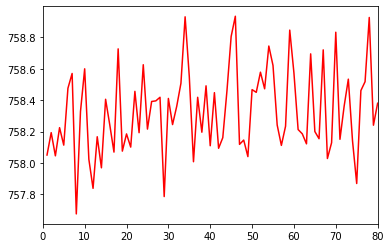

exec_time: 54.87991404533386
DM_option: [  0.         0.         0.         0.         0.        56.581675
   0.         0.       443.418325]
BP_option: [  0.         8.946715   1.796045  26.19993    0.        21.87702
   0.         0.       441.18029 ]
Max Exp: 758.9345189687539


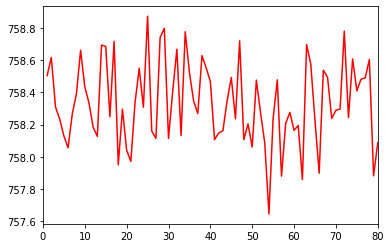

exec_time: 55.02591109275818
DM_option: [  0.         0.         0.         0.        18.89928    7.234925
  39.15095  434.71485    0.      ]
BP_option: [  0.         0.         0.        12.017495   0.         0.
   0.       209.72736  278.25514 ]
Max Exp: 758.8723538641245
Mean_Time: 55.02591109275818
Mean Fitness: 758.876139170529
---------POP SIZE: 120 ------------


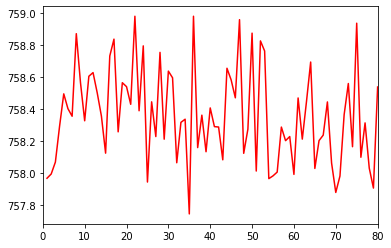

exec_time: 59.49656677246094
DM_option: [  0.        0.        0.        0.       13.52615   0.      116.19198
  12.98062 357.30125]
BP_option: [  0.         8.046635   0.         0.         0.         0.
   1.3515     0.       490.601865]
Max Exp: 758.9819192022419


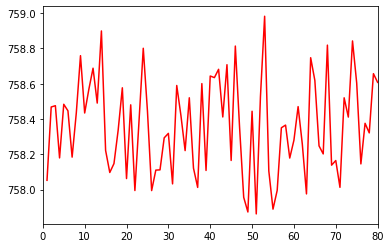

exec_time: 59.7483549118042
DM_option: [  0.         4.598315   0.         0.        21.87451   21.09137
   0.       135.92039  316.515415]
BP_option: [  0.         0.         0.         0.         0.         0.
   0.       114.740995 385.259005]
Max Exp: 758.9819192022419


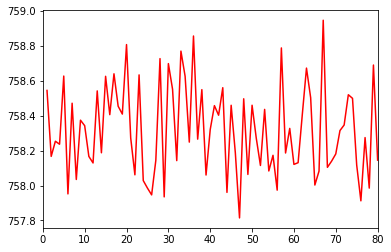

exec_time: 59.071232080459595
DM_option: [  0.         2.97911    0.         0.         0.         0.
 231.512915 265.507975   0.      ]
BP_option: [  0.         0.         0.         0.         0.         0.
  10.182245  27.96397  461.85378 ]
Max Exp: 758.9450508417115


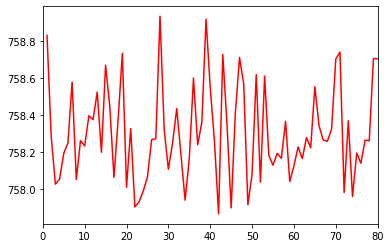

exec_time: 59.44391989707947
DM_option: [  0.         0.        15.210105   0.         0.        77.059955
   0.         0.       407.72994 ]
BP_option: [  0.        0.        0.        0.        0.       20.52621   0.
   0.      479.47379]
Max Exp: 758.9315806698065


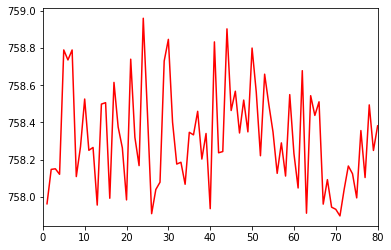

exec_time: 62.0540132522583
DM_option: [  0.         0.         0.         0.        18.803275   8.98142
   8.539315 245.151945 218.52405 ]
BP_option: [  0.   0.   0.   0.   0.   0.   0. 500.   0.]
Max Exp: 758.9606264055523
Mean_Time: 62.0540132522583
Mean Fitness: 758.9602192643108


In [0]:
for i in range(50, 121, 10):
    exec_vector = []
    fitness_vector = []
    print('---------POP SIZE:', i, '------------')
    for _ in range(5):
        exec_time, GLOBAL_BEST = evolution(i, i*7, 80, 1)
        exec_vector.append(exec_time)
        fitness_vector.append(GLOBAL_BEST)
    print('Mean_Time:', np.mean(exec_time))
    print('Mean Fitness:', np.mean(fitness_vector))


In [0]:
np.mean(fitness_vector)

758.82858469525

### Calculate Maximun Prob of  Rev more than USD $706 

---------POP SIZE: 50 ------------


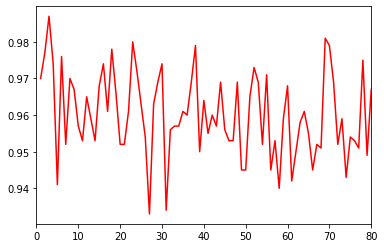

exec_time: 30.861523389816284
DM_option: [  0.       327.105465 146.47109    0.         0.         0.
   0.        26.42345    0.      ]
BP_option: [ 85.832485 216.402345   0.        48.406605   0.         0.
  77.01827   72.340295   0.      ]
More than USD $706 Prob: 0.987
1-prob: 0.013000000000000012


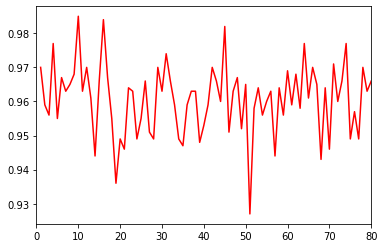

exec_time: 32.75623393058777
DM_option: [  0.       442.141565   0.         0.         4.16879   46.11652
   0.         7.57312    0.      ]
BP_option: [  0.       330.92855    4.316475   5.126945  28.519735   0.
  63.382425   0.        67.72587 ]
More than USD $706 Prob: 0.985
1-prob: 0.015000000000000013


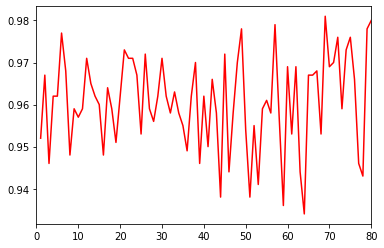

exec_time: 29.719143867492676
DM_option: [  0. 500.   0.   0.   0.   0.   0.   0.   0.]
BP_option: [  0.       352.87895    0.        12.884465   0.         0.
   0.       102.263695  31.972895]
More than USD $706 Prob: 0.981
1-prob: 0.019000000000000017


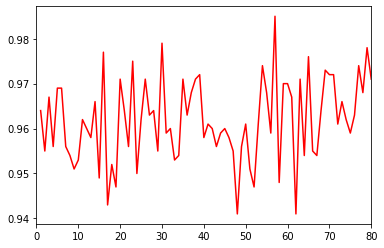

exec_time: 33.77460980415344
DM_option: [  0.      435.88929  64.11071   0.        0.        0.        0.
   0.        0.     ]
BP_option: [  0.      304.58283   0.        0.        0.      195.41717   0.
   0.        0.     ]
More than USD $706 Prob: 0.985
1-prob: 0.015000000000000013


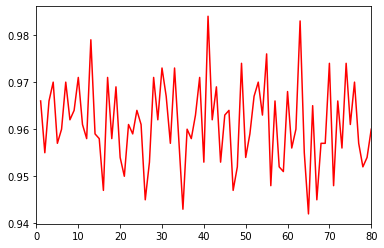

exec_time: 34.09319806098938
DM_option: [  0.        47.34221  327.3594    85.106405   8.481235  12.53725
  19.173495   0.         0.      ]
BP_option: [ 27.357685 287.464465   0.        29.02525   20.06478  129.506945
   0.         6.58087    0.      ]
More than USD $706 Prob: 0.984
1-prob: 0.016000000000000014
-----------MEAN-----------
Mean_Time: 34.09319806098938
Mean Fitness: 0.9843999999999999
---------POP SIZE: 60 ------------


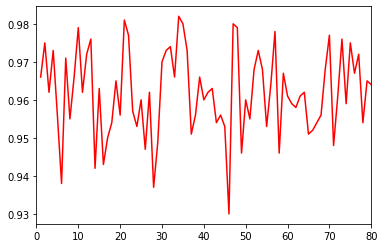

exec_time: 41.06298089027405
DM_option: [  0.       145.17246  163.56215  169.674215   0.         6.916385
  14.67479    0.         0.      ]
BP_option: [ 32.173035 213.234055  93.823665   0.         0.         0.
 160.769245   0.         0.      ]
More than USD $706 Prob: 0.982
1-prob: 0.018000000000000016


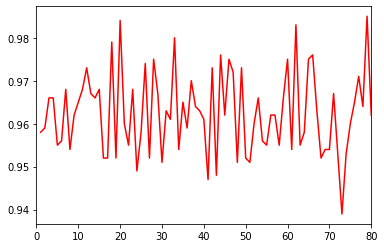

exec_time: 41.162378787994385
DM_option: [  0.   0. 500.   0.   0.   0.   0.   0.   0.]
BP_option: [ 29.65812    0.       375.60399   23.019415   0.         0.
  71.718475   0.         0.      ]
More than USD $706 Prob: 0.985
1-prob: 0.015000000000000013


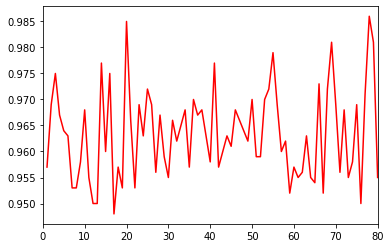

exec_time: 41.39706993103027
DM_option: [  0. 500.   0.   0.   0.   0.   0.   0.   0.]
BP_option: [ 50.76053  221.524415   0.         0.         0.         0.
   0.       218.279205   9.435845]
More than USD $706 Prob: 0.986
1-prob: 0.014000000000000012


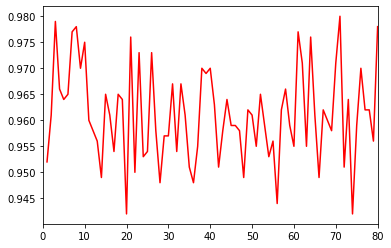

exec_time: 33.1347770690918
DM_option: [  0.       41.87853 443.19357  14.9279    0.        0.        0.
   0.        0.     ]
BP_option: [167.85004  196.177445   0.         0.         0.         0.
   0.         0.       135.972515]
More than USD $706 Prob: 0.98
1-prob: 0.020000000000000018


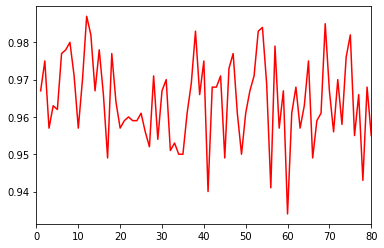

exec_time: 33.47357416152954
DM_option: [  0.        0.      446.70299  20.4337    0.        0.       32.86331
   0.        0.     ]
BP_option: [137.76952  143.045845   0.         0.       144.08136    0.
  75.10328    0.         0.      ]
More than USD $706 Prob: 0.987
1-prob: 0.013000000000000012
-----------MEAN-----------
Mean_Time: 33.47357416152954
Mean Fitness: 0.984
---------POP SIZE: 70 ------------


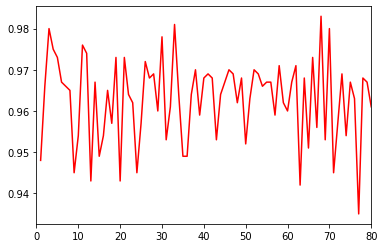

exec_time: 37.98675727844238
DM_option: [  0. 500.   0.   0.   0.   0.   0.   0.   0.]
BP_option: [  0.        35.395695 294.21685    2.93191   10.30568    0.
   0.779835   0.       156.37003 ]
More than USD $706 Prob: 0.983
1-prob: 0.017000000000000015


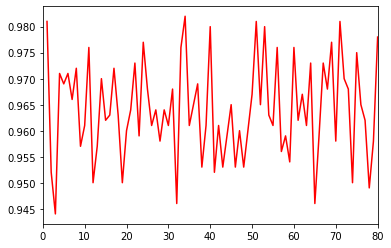

exec_time: 37.74513792991638
DM_option: [  0.      436.99399  63.00601   0.        0.        0.        0.
   0.        0.     ]
BP_option: [  0.       370.427175   0.         0.         0.         3.243285
   0.         0.       126.32954 ]
More than USD $706 Prob: 0.982
1-prob: 0.018000000000000016


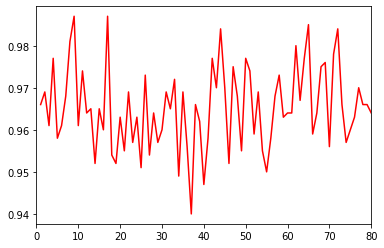

exec_time: 37.531105041503906
DM_option: [  0.   0. 500.   0.   0.   0.   0.   0.   0.]
BP_option: [237.731425   0.       109.356865   0.         0.       152.91171
   0.         0.         0.      ]
More than USD $706 Prob: 0.987
1-prob: 0.013000000000000012


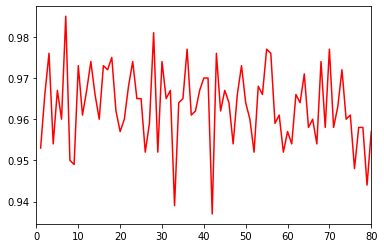

exec_time: 37.498226165771484
DM_option: [  0.   0. 500.   0.   0.   0.   0.   0.   0.]
BP_option: [  0.       264.367305   0.         0.         0.         0.
   0.       235.632695   0.      ]
More than USD $706 Prob: 0.985
1-prob: 0.015000000000000013


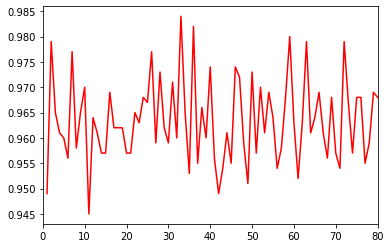

exec_time: 37.70930004119873
DM_option: [  0.         0.       484.341605   0.         0.         7.393605
   0.         0.         8.26479 ]
BP_option: [152.378015 172.043105   0.         0.         0.       155.37308
   0.         5.39982   14.80598 ]
More than USD $706 Prob: 0.984
1-prob: 0.016000000000000014
-----------MEAN-----------
Mean_Time: 37.70930004119873
Mean Fitness: 0.9841999999999999
---------POP SIZE: 80 ------------


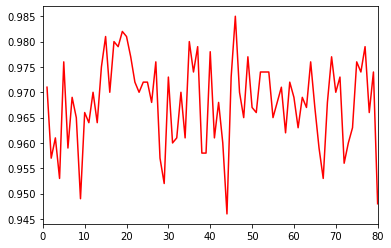

exec_time: 41.95107579231262
DM_option: [  0.      406.49571   0.        0.        0.       93.50429   0.
   0.        0.     ]
BP_option: [101.694805  59.057965 201.302665   0.        17.168265  50.7699
   3.736525   0.        66.26987 ]
More than USD $706 Prob: 0.985
1-prob: 0.015000000000000013


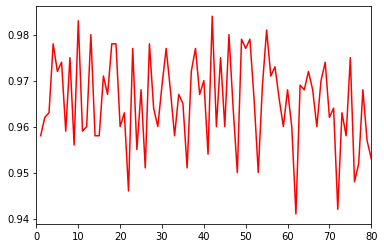

exec_time: 41.853041887283325
DM_option: [  0.        26.165975 369.71718   47.188635   0.        56.92821
   0.         0.         0.      ]
BP_option: [  0.        39.994295 399.235525   0.         0.         0.
   0.         0.        60.77018 ]
More than USD $706 Prob: 0.984
1-prob: 0.016000000000000014


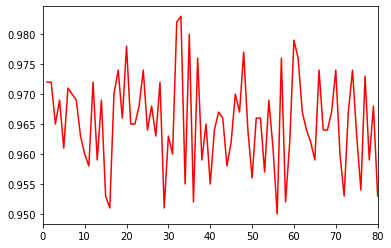

exec_time: 43.888757944107056
DM_option: [ 11.961355  11.220815 474.80071    0.         2.01712    0.
   0.         0.         0.      ]
BP_option: [ 77.639415  13.20708  173.699655  87.954565   0.        19.04891
 128.450375   0.         0.      ]
More than USD $706 Prob: 0.983
1-prob: 0.017000000000000015


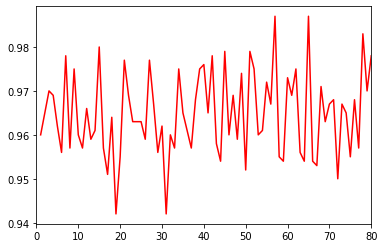

exec_time: 52.459754943847656
DM_option: [  0.       132.86075  310.837255  56.301995   0.         0.
   0.         0.         0.      ]
BP_option: [  0.       349.528675  16.367195   0.         0.         0.
 134.10413    0.         0.      ]
More than USD $706 Prob: 0.987
1-prob: 0.013000000000000012


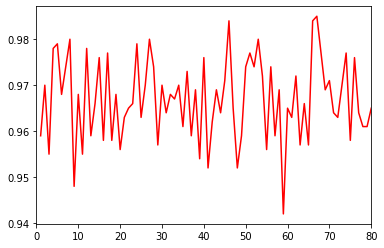

exec_time: 46.53085803985596
DM_option: [  0.        0.      390.31508  45.90016   0.        0.       63.78476
   0.        0.     ]
BP_option: [ 19.739665 283.27205    0.         0.        13.912285   0.
 133.279265  46.353605   3.44313 ]
More than USD $706 Prob: 0.985
1-prob: 0.015000000000000013
-----------MEAN-----------
Mean_Time: 46.53085803985596
Mean Fitness: 0.9848000000000001
---------POP SIZE: 90 ------------


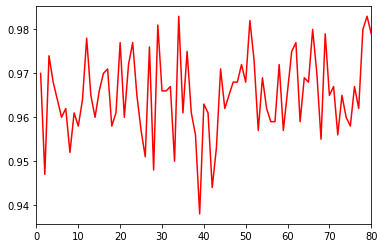

exec_time: 46.41919493675232
DM_option: [  0.       192.039785 285.57426   22.385955   0.         0.
   0.         0.         0.      ]
BP_option: [  0.      321.89699   0.        0.        0.        0.      178.10301
   0.        0.     ]
More than USD $706 Prob: 0.983
1-prob: 0.017000000000000015


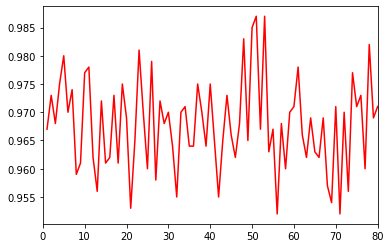

exec_time: 47.74908113479614
DM_option: [  0.   0. 500.   0.   0.   0.   0.   0.   0.]
BP_option: [1.32162725e+02 1.33611815e+02 4.41137500e+01 0.00000000e+00
 0.00000000e+00 1.89954215e+02 0.00000000e+00 1.57490000e-01
 0.00000000e+00]
More than USD $706 Prob: 0.987
1-prob: 0.013000000000000012


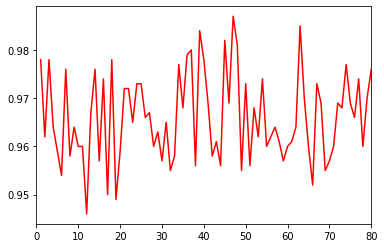

exec_time: 46.8371479511261
DM_option: [  0.        33.547735 453.484755   0.         0.        12.96751
   0.         0.         0.      ]
BP_option: [  0.       290.46265    0.        10.53296  106.64256    0.
   0.34534   92.016485   0.      ]
More than USD $706 Prob: 0.987
1-prob: 0.013000000000000012


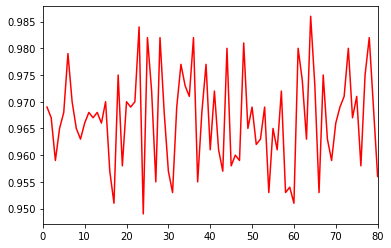

exec_time: 46.28052496910095
DM_option: [  0.        83.593715  70.069595 335.800355   0.         0.
   0.         0.        10.53634 ]
BP_option: [ 37.17938  229.98445   86.986905  12.472075   0.         0.
   0.       112.65062   20.726575]
More than USD $706 Prob: 0.986
1-prob: 0.014000000000000012


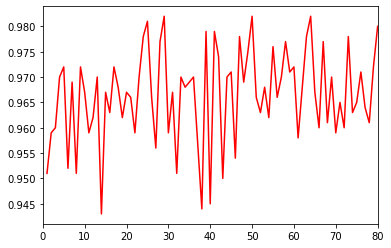

exec_time: 46.85971283912659
DM_option: [  0.   0. 500.   0.   0.   0.   0.   0.   0.]
BP_option: [  2.72091  180.09318  184.57374    0.         0.         0.
   0.       132.612175   0.      ]
More than USD $706 Prob: 0.982
1-prob: 0.018000000000000016
-----------MEAN-----------
Mean_Time: 46.85971283912659
Mean Fitness: 0.985
---------POP SIZE: 100 ------------


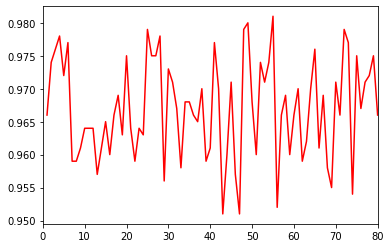

exec_time: 53.16999292373657
DM_option: [  0.         0.       282.438485 217.561515   0.         0.
   0.         0.         0.      ]
BP_option: [  0.       290.25697    0.         7.398985  82.952735   0.
  10.72772  103.21261    5.45098 ]
More than USD $706 Prob: 0.981
1-prob: 0.019000000000000017


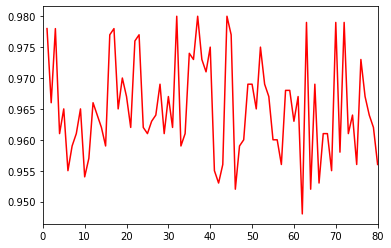

exec_time: 51.20461702346802
DM_option: [  0.       469.926875   0.         0.         0.         0.
  16.71112    0.        13.362005]
BP_option: [145.82128  132.97592    0.        67.329565   0.         0.
   0.         0.       153.87323 ]
More than USD $706 Prob: 0.98
1-prob: 0.020000000000000018


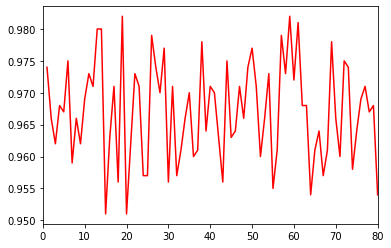

exec_time: 50.88731122016907
DM_option: [  0.       411.2776    49.710955  16.48931    0.         0.
   0.         0.        22.522135]
BP_option: [  0.       289.542765   0.         0.         0.         0.
  64.99953  145.457705   0.      ]
More than USD $706 Prob: 0.982
1-prob: 0.018000000000000016


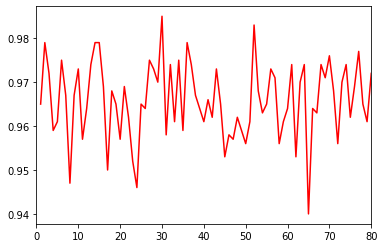

exec_time: 51.66223168373108
DM_option: [  0.        59.817015 386.66078   47.92564    0.         0.
   0.         0.         5.596565]
BP_option: [  0.       270.388895   0.        49.476085   0.         0.
  75.495695   0.       104.639325]
More than USD $706 Prob: 0.985
1-prob: 0.015000000000000013


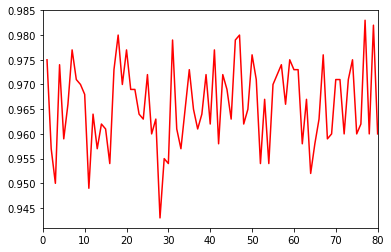

exec_time: 57.267717123031616
DM_option: [  0.         0.       441.363275   0.        21.52345    0.
  37.11328    0.         0.      ]
BP_option: [ 73.41168 162.84664   0.      141.84528   0.       25.47719   0.
  96.41921   0.     ]
More than USD $706 Prob: 0.983
1-prob: 0.017000000000000015
-----------MEAN-----------
Mean_Time: 57.267717123031616
Mean Fitness: 0.9822
---------POP SIZE: 110 ------------


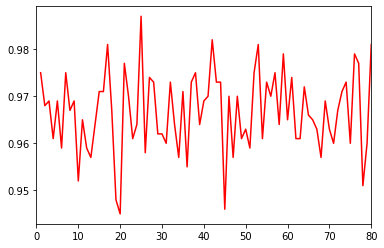

exec_time: 68.245521068573
DM_option: [0.00000000e+00 3.33480945e+02 1.45918255e+02 3.03095000e-01
 2.02977050e+01 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00]
BP_option: [1.19192050e+01 3.31693350e+02 0.00000000e+00 1.08373750e+01
 0.00000000e+00 0.00000000e+00 1.78520000e-01 0.00000000e+00
 1.45371545e+02]
More than USD $706 Prob: 0.987
1-prob: 0.013000000000000012


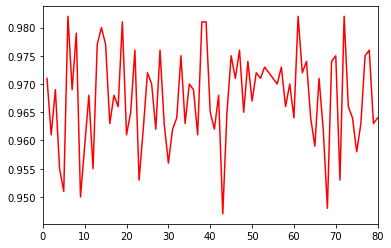

exec_time: 64.47471690177917
DM_option: [  0.       362.88892   75.727015  13.166305   0.        48.217765
   0.         0.         0.      ]
BP_option: [106.976935 194.253025  85.245555   0.         0.         0.
  66.665655  46.85883    0.      ]
More than USD $706 Prob: 0.982
1-prob: 0.018000000000000016


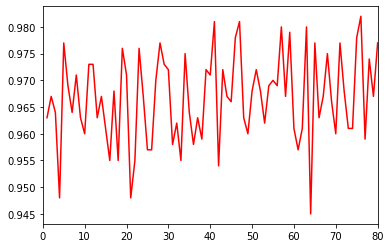

exec_time: 63.15111589431763
DM_option: [  0.       185.628905 258.59636   50.363215   0.         0.
   0.         5.411515   0.      ]
BP_option: [ 91.512005 216.359445   0.         0.        24.86198    0.
   0.       167.26657    0.      ]
More than USD $706 Prob: 0.982
1-prob: 0.018000000000000016


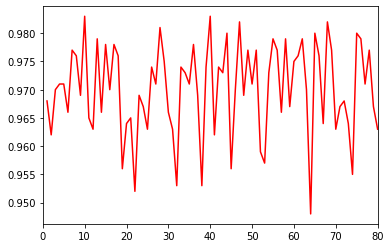

exec_time: 59.012239933013916
DM_option: [  0.       269.73214  197.678465   3.314685  23.14295    0.
   0.         0.         6.131765]
BP_option: [147.32343  168.580025  56.701      0.        46.751855   0.
   0.        80.643685   0.      ]
More than USD $706 Prob: 0.983
1-prob: 0.017000000000000015


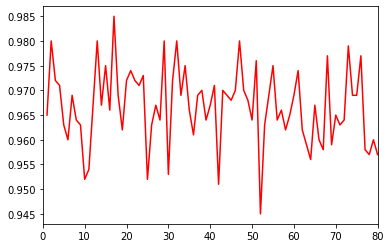

exec_time: 57.01151990890503
DM_option: [  0.        0.      310.90211   0.      113.87736  75.22053   0.
   0.        0.     ]
BP_option: [  0.      263.41072  63.2081    0.        0.        0.        0.
 173.38118   0.     ]
More than USD $706 Prob: 0.985
1-prob: 0.015000000000000013
-----------MEAN-----------
Mean_Time: 57.01151990890503
Mean Fitness: 0.9837999999999999
---------POP SIZE: 120 ------------


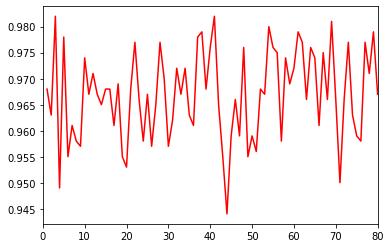

exec_time: 61.5612428188324
DM_option: [  0.      323.23807 176.76193   0.        0.        0.        0.
   0.        0.     ]
BP_option: [  0.       271.80011   66.400845  94.49099    9.759605   0.
   0.        16.353035  41.19541 ]
More than USD $706 Prob: 0.982
1-prob: 0.018000000000000016


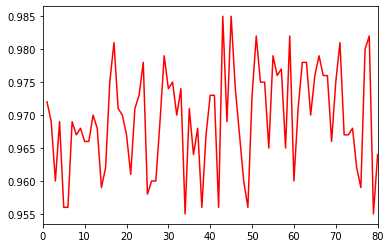

exec_time: 62.09574294090271
DM_option: [  0.       285.748185 214.251815   0.         0.         0.
   0.         0.         0.      ]
BP_option: [134.07739  132.35321   91.36586   12.71223   50.03045    0.
  37.239495   0.        42.221365]
More than USD $706 Prob: 0.985
1-prob: 0.015000000000000013


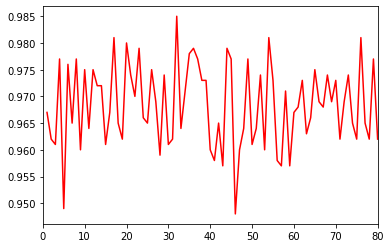

exec_time: 61.42605018615723
DM_option: [  0.         0.       422.78179    2.562705  11.373905   0.
  20.130955  43.150645   0.      ]
BP_option: [  8.71647  362.61495    0.         0.         0.         0.
 128.668575   0.         0.      ]
More than USD $706 Prob: 0.985
1-prob: 0.015000000000000013


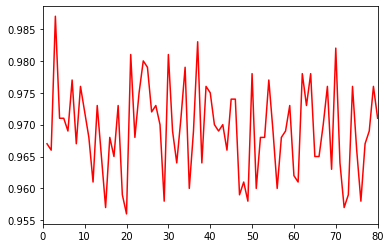

exec_time: 61.13276791572571
DM_option: [  4.539795   0.       444.525385   0.         0.         0.
  17.509125  33.42569    0.      ]
BP_option: [ 28.577225 314.451415   0.         0.         0.         0.
   0.       156.97136    0.      ]
More than USD $706 Prob: 0.987
1-prob: 0.013000000000000012


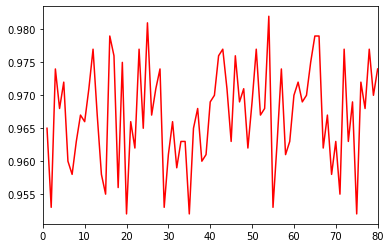

exec_time: 61.671591997146606
DM_option: [  0.        0.      446.46636   0.       53.53364   0.        0.
   0.        0.     ]
BP_option: [112.700395 252.413325   0.         7.38611    0.         0.
  62.51523    0.        64.98494 ]
More than USD $706 Prob: 0.982
1-prob: 0.018000000000000016
-----------MEAN-----------
Mean_Time: 61.671591997146606
Mean Fitness: 0.9842000000000001


In [0]:
for i in range(50, 121, 10):
    exec_vector = []
    fitness_vector = []
    print('---------POP SIZE:', i, '------------')
    for _ in range(5):
        exec_time, GLOBAL_BEST = evolution(i, i*7, 80, 0)
        exec_vector.append(exec_time)
        fitness_vector.append(GLOBAL_BEST)
    print('-----------MEAN-----------')
    print('Mean_Time:', np.mean(exec_time))
    print('Mean Fitness:', np.mean(fitness_vector))

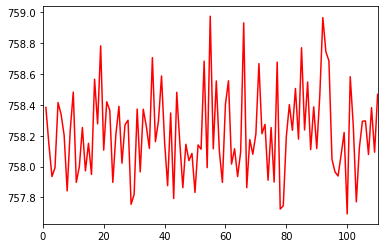

exec_time: 57.10173487663269
DM_option: [  0.         0.         3.40518    0.         3.009975   0.
   3.384625  18.364745 471.835475]
BP_option: [  0.         0.         0.         0.         0.        97.932675
   0.       402.067325   0.      ]
Max Exp: 758.9748165029796


(57.10173487663269, 758.9748165029796)

In [0]:
evolution(70, 490, 110, 1)

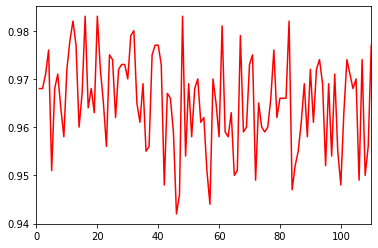

exec_time: 72.63016605377197
DM_option: [ 11.394025 285.190855 184.360175  16.596685   0.         0.
   2.45826    0.         0.      ]
BP_option: [  0.       266.502555  59.424365   0.         0.        30.498645
   0.       111.715635  31.8588  ]
More than USD $706 Prob: 0.983
1-prob: 0.017000000000000015


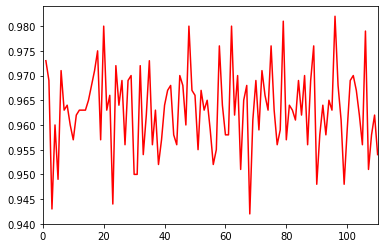

exec_time: 63.386104106903076
DM_option: [  2.958525 163.856765 311.488065   0.         0.         3.978825
   9.353235   8.36459    0.      ]
BP_option: [  0.       255.51212    6.76913  171.277665   2.307695  64.13339
   0.         0.         0.      ]
More than USD $706 Prob: 0.982
1-prob: 0.018000000000000016


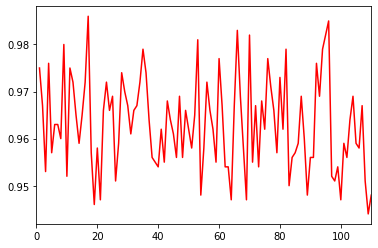

exec_time: 69.17965602874756
DM_option: [  0.       431.236375   0.         0.        68.763625   0.
   0.         0.         0.      ]
BP_option: [183.038315   0.       108.06311   12.519305  95.11478    0.
   0.         0.       101.26449 ]
More than USD $706 Prob: 0.986
1-prob: 0.014000000000000012


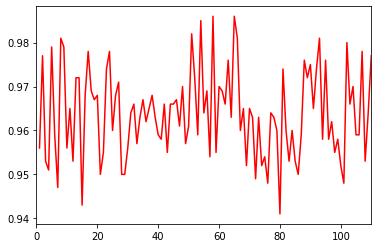

exec_time: 71.50509691238403
DM_option: [  0.       90.83801 396.36002   0.        0.        0.        0.
   0.       12.80197]
BP_option: [  0.       371.337905   0.         0.         0.         0.
   0.       128.662095   0.      ]
More than USD $706 Prob: 0.986
1-prob: 0.014000000000000012


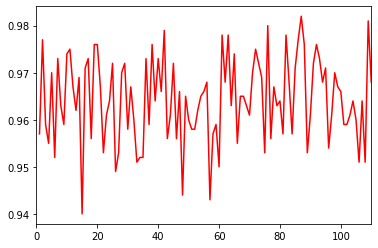

exec_time: 66.68867301940918
DM_option: [  0.        86.34963  376.13529    0.        31.78673    0.
   2.751525   1.423885   1.55294 ]
BP_option: [103.31677  210.817225   0.         0.        89.09688    0.
   0.        56.62154   40.147585]
More than USD $706 Prob: 0.982
1-prob: 0.018000000000000016
-----------MEAN-----------
Mean_Time: 66.68867301940918
Mean Fitness: 0.9837999999999999


In [0]:
exec_vector = []
fitness_vector = []
#     print('---------POP SIZE:', i, '------------')
for _ in range(5):
    exec_time, GLOBAL_BEST = evolution(70, 490, 110, 0)
    exec_vector.append(exec_time)
    fitness_vector.append(GLOBAL_BEST)
print('-----------MEAN-----------')
print('Mean_Time:', np.mean(exec_time))
print('Mean Fitness:', np.mean(fitness_vector))

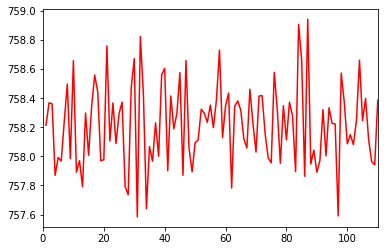

exec_time: 54.23760223388672
DM_option: [  0.         0.         0.         0.         0.       199.649505
   0.         0.       300.350495]
BP_option: [  0.        0.        0.        0.        0.        5.33809   0.
 385.22106 109.44085]
Max Exp: 758.9405830320734


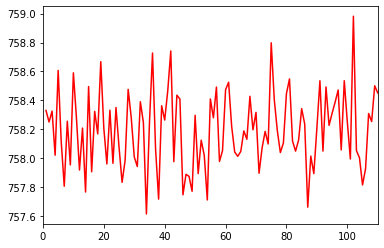

exec_time: 55.91591024398804
DM_option: [  0.        0.        0.        0.        0.        0.       88.24426
   0.      411.75574]
BP_option: [  0.        0.        0.        0.        0.        0.      249.24819
 123.37008 127.38173]
Max Exp: 758.9819192022419


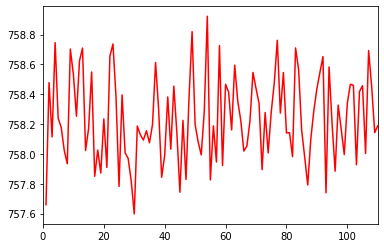

exec_time: 60.716920137405396
DM_option: [  0.         0.         0.         0.        68.525155  42.110165
   0.         0.       389.36468 ]
BP_option: [  0.         0.         0.         0.         0.         0.
 404.265805   0.        95.734195]
Max Exp: 758.922935784659


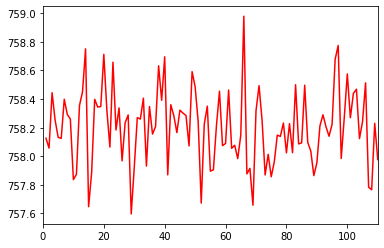

exec_time: 66.40371894836426
DM_option: [  6.97628    0.        71.062255  18.804805   0.        29.14117
  54.81435    0.       319.201135]
BP_option: [  0.   0.   0.   0.   0.   0.   0. 500.   0.]
Max Exp: 758.9796222939015


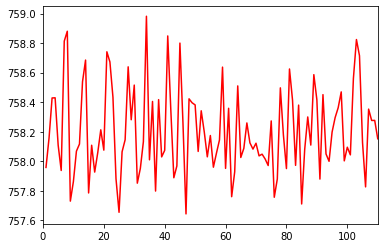

exec_time: 64.05320382118225
DM_option: [  0.         0.        28.304545   0.         0.         0.
  95.82491  287.454335  88.416215]
BP_option: [  0.   0.   0.   0.   0.   0.   0. 500.   0.]
Max Exp: 758.9819192022419
-----------MEAN-----------
Mean_Time: 64.05320382118225
Mean Fitness: 758.9613959030235


In [0]:
exec_vector = []
fitness_vector = []
#     print('---------POP SIZE:', i, '------------')
for _ in range(5):
    exec_time, GLOBAL_BEST = evolution(70, 490, 110, 1)
    exec_vector.append(exec_time)
    fitness_vector.append(GLOBAL_BEST)
print('-----------MEAN-----------')
print('Mean_Time:', np.mean(exec_time))
print('Mean Fitness:', np.mean(fitness_vector))

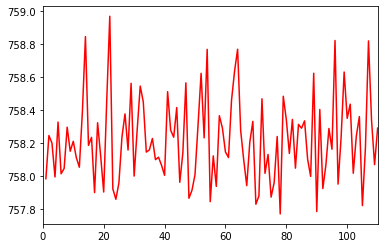

exec_time: 69.33296370506287
DM_option: [  0.        0.       14.05229   0.        0.      141.90729   0.
   0.      344.04042]
BP_option: [  0.         6.297875   0.         0.        16.28324    0.
  73.744635  26.58975  377.0845  ]
Max Exp: 758.9679972503983


(69.33296370506287, 758.9679972503983)

In [0]:
evolution(70, 600, 110, 1)